In [6]:
import statsmodels
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import os

import sklearn
import torch
import torch.nn

from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns

DATA_DIR = '../data/'

In [49]:
#The evaluation metrics
def mrse(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)

    denom = np.sqrt(np.sum(np.square(actuals - np.mean(actuals))))
    num = np.sqrt(np.sum(np.square(actuals - preds)))

    return 1.0*num/denom

def re(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)
    denom = np.sqrt(np.sum(np.square(actuals)))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [10]:
#Reading nino 34
filename = 'nino34_data.txt'
data = open(DATA_DIR + filename)
data_dict = {}

for line in data.readlines()[1:-3]:
    
    tokens = line.split(' ')
    values = []
    for token in tokens:
        if token == '':
            pass
        else:
            if '\n' in token:
                token = token[:-2]
            values.append(float(token))
    data_dict.update({values[0]:values[1:]})

In [11]:
filtered_data = {int(year): data_dict[year] for year in data_dict.keys() if year >= 1950 and year <=2008 }

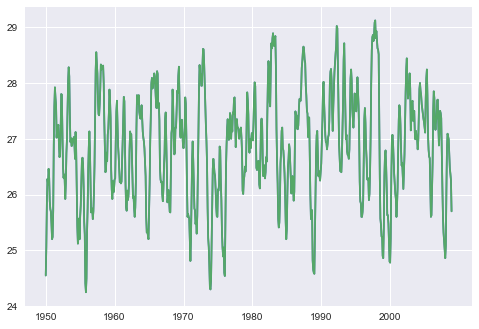

In [13]:
filtered_ts = np.array([])
filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()
plt.plot(filtered_ts)
plt.xticks(range(0,708+1,12*10),range(1950,2008+1,10))
plt.show()

In [14]:
def get_data(data,years,subtract_mean=False,means=None):
    if subtract_mean == True:
        assert means is not None
    filtered_data = {int(year): data[year] for year in data.keys() if year in years }
    filtered_ts = np.array([])
    if subtract_mean:
        filtered_ts = np.array([np.concatenate((filtered_ts,val-means)) for val in filtered_data.values()]).flatten()
    else:
        filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()
    return filtered_ts

In [15]:
train_test_ratio = 0.8
years = np.array(list(filtered_data.keys()))
print('Total years available')
print(years)
print(f'Train Test ratio: {train_test_ratio}')
training_years = years[:int(train_test_ratio*len(years))]
print(f'No of years in training: {len(training_years)}')
print(training_years)
testing_years = years[int(train_test_ratio*len(years)):]
print(f'No of years in testing: {len(testing_years)}')
print(testing_years)

Total years available
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008]
Train Test ratio: 0.8
No of years in training: 47
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996]
No of years in testing: 12
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008]


In [16]:
means = np.zeros(12)
for key,value in filtered_data.items():
    if int(key) in training_years:
        means += np.array(value)
means /= len(training_years)
print(means)

[26.43340426 26.63085106 27.10021277 27.51       27.61638298 27.42085106
 26.98765957 26.58851064 26.47744681 26.43723404 26.42957447 26.37021277]


In [17]:
for key,value in filtered_data.items():
    print(key,value-means)
    assert len(value) == 12

1950 [-1.88340426 -1.57085106 -1.23021277 -1.23       -1.43638298 -0.96085106
 -0.69765957 -0.70851064 -0.73744681 -0.74723404 -0.95957447 -1.17021277]
1951 [-1.19340426 -0.92085106 -0.20021277  0.07        0.30361702  0.30914894
  0.61234043  0.43148936  0.75255319  0.76276596  0.82042553  0.52978723]
1952 [ 0.23659574  0.10914894  0.06978723  0.29        0.17361702 -0.24085106
 -0.45765957 -0.28851064 -0.11744681 -0.17723404 -0.50957447 -0.17021277]
1953 [0.30659574 0.36914894 0.46978723 0.53       0.66361702 0.69914894
 0.44234043 0.35148936 0.53255319 0.43276596 0.45042553 0.62978723]
1954 [ 0.54659574  0.39914894 -0.20021277 -0.87       -0.49638298 -0.62085106
 -0.87765957 -1.15851064 -1.35744681 -1.20723404 -0.85957447 -1.17021277]
1955 [-0.82340426 -0.82085106 -0.88021277 -0.91       -0.95638298 -0.87085106
 -0.83765957 -1.07851064 -1.19744681 -2.02723404 -2.17957447 -1.87021277]
1956 [-1.09340426 -0.87085106 -0.64021277 -0.66       -0.48638298 -0.61085106
 -0.75765957 -0.908510

In [20]:
training_data = get_data(filtered_data,training_years,subtract_mean=True,means=means)
test_data = get_data(filtered_data,testing_years,subtract_mean=True,means=means)
assert len(training_years)*12 == len(training_data)
len(training_data)

564

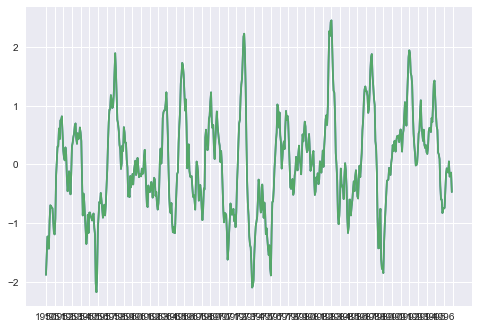

In [22]:
plt.plot(training_data)
plt.xticks(range(0,len(training_data)+1,12),training_years)
plt.show()


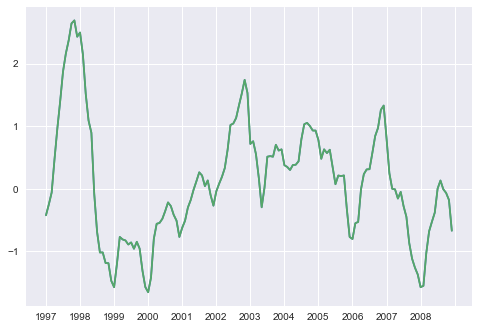

In [24]:
plt.plot(test_data)
plt.xticks(range(0,len(test_data)+1,12),testing_years)
plt.show()

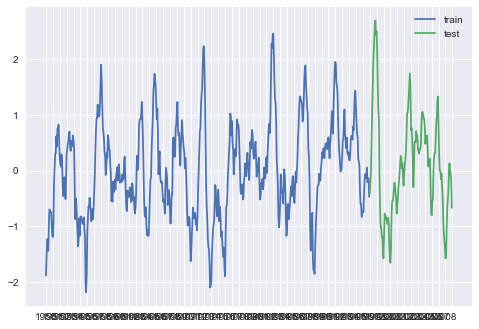

In [25]:
plt.plot(range(0,len(training_data)),training_data,label='train')
plt.plot(range(len(training_data),len(training_data)+len(test_data)),test_data,label='test')
plt.xticks(range(0,len(training_data)+len(test_data)+1,12),list(training_years)+list(testing_years))
plt.legend()
plt.show()

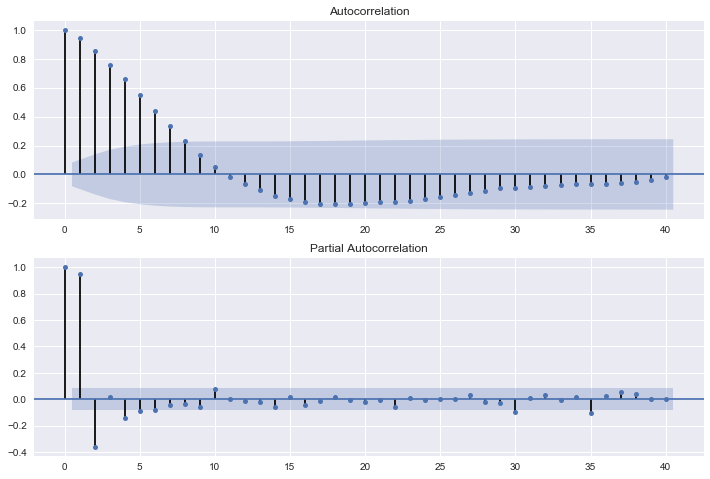

In [26]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data, lags=40, ax=ax2)
plt.show()

In [27]:
formatted_training_data = pd.Series(data=training_data,index=pd.Index(sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_data))))

In [29]:
p=5
arma_mod = sm.tsa.ARMA(formatted_training_data, (p,0)).fit(disp=False)
print(arma_mod.params)

/Users/radhikanikam/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


const     -0.026984
ar.L1.y    1.332269
ar.L2.y   -0.483332
ar.L3.y    0.188113
ar.L4.y   -0.047334
ar.L5.y   -0.072128
dtype: float64


In [33]:
#training_predictions = arma_mod.predict(start=f'{training_years[0]}m1', end=f'{training_years[-1]}m12', dynamic=False)

dates = (sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_years)*12))

training_predictions = arma_mod.predict(start=dates[0], 
    end=dates[-1], dynamic=False)

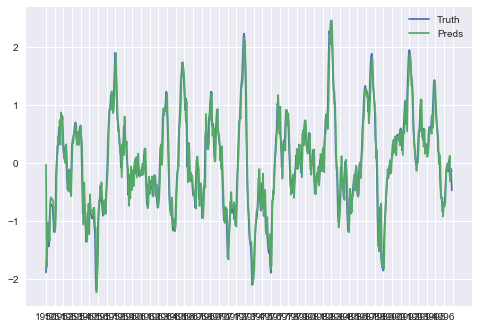

In [36]:
plt.plot(formatted_training_data.values,label='Truth')
plt.plot(training_predictions.values,label='Preds')
plt.xticks(range(0,len(training_data)+1,12),training_years)
plt.legend()
plt.show()

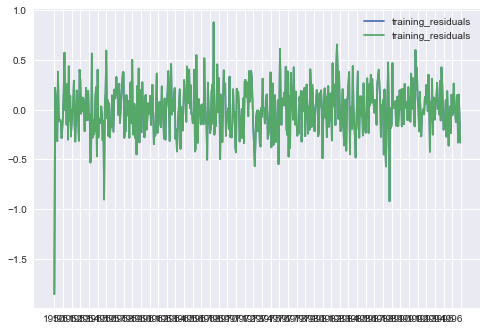

In [38]:
training_residuals = formatted_training_data.values-training_predictions.values
plt.plot(training_residuals,label='training_residuals')
plt.xticks(range(0,len(training_data)+1,12),training_years)
plt.legend()
plt.show()

/Users/radhikanikam/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


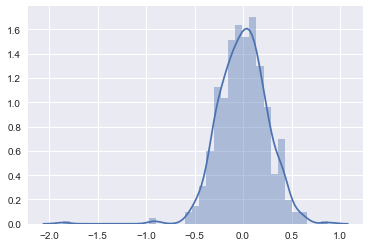

In [40]:
%matplotlib inline
sns.distplot(training_residuals)

In [41]:
history = list(formatted_training_data.values)
test_predictions = []
for t in range(len(test_data)):
    arma_model = sm.tsa.ARMA(history, (p,0)).fit(disp=False)
    output = arma_model.forecast()
    yhat = output[0][0]
    test_predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)

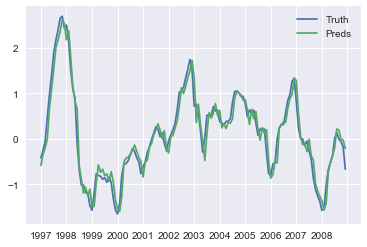

In [43]:
plt.plot(test_data,label='Truth')
plt.plot(test_predictions,label='Preds')
plt.xticks(range(0,len(test_data)+1,12),testing_years)
plt.legend()
plt.show()

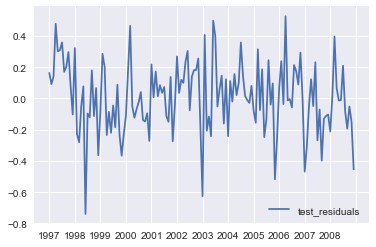

In [45]:
test_residuals = np.array(test_data)-np.array(test_predictions)
plt.plot(test_residuals,label='test_residuals')
plt.xticks(range(0,len(test_data)+1,12),testing_years)
plt.legend()
plt.show()

/Users/radhikanikam/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


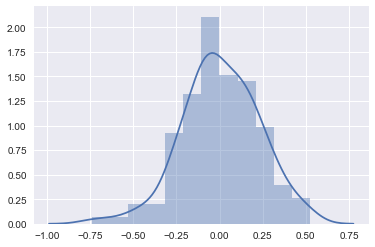

In [46]:
sns.distplot(test_residuals)

In [50]:
def error(actuals, preds):
    actuals = np.array(actuals)
    preds = np.array(preds)
    return np.sqrt(np.mean(np.square(actuals-preds)))


test_mrse = mrse(test_data,test_predictions)
test_re = re(test_data,test_predictions)
test_error = error(test_data,test_predictions)
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}\nTest ERROR: {test_error}')

Test MRSE: 0.23611965122143397
Test RE: 0.23454133761795243
Test ERROR: 0.22240639236123275


In [51]:
new_training_data = training_residuals
new_test_data = test_residuals

In [52]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_training_data = scaler.fit_transform(new_training_data.reshape(-1, 1))
scaled_test_data = scaler.transform(new_test_data.reshape(-1, 1))

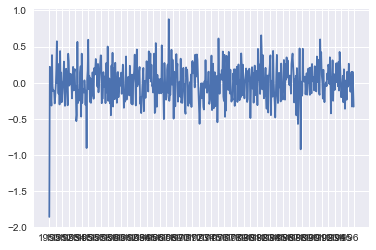

In [53]:
plt.plot(new_training_data)
#plt.plot(reqd_means)
plt.xticks(range(0,len(new_training_data)+1,12),training_years)
plt.show()

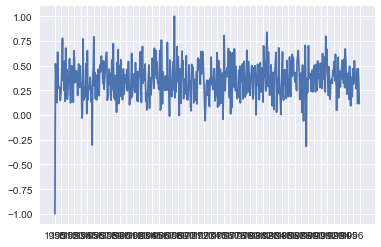

In [54]:
plt.plot(scaled_training_data)
#plt.plot(reqd_means)
plt.xticks(range(0,len(new_training_data)+1,12),training_years)
plt.show()

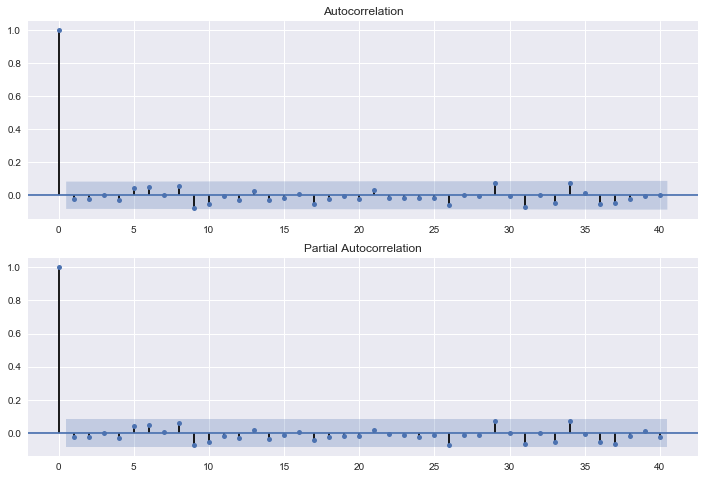

In [55]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(scaled_training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(scaled_training_data, lags=40, ax=ax2)
plt.show()

In [56]:
train_data_normalized = torch.FloatTensor(new_training_data).view(-1)
train_window = p

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

train_inout_seq[:5]

[(tensor([-1.8564,  0.2203,  0.1101, -0.2089, -0.3168]), tensor([0.3817])),
 (tensor([ 0.2203,  0.1101, -0.2089, -0.3168,  0.3817]), tensor([-0.0497])),
 (tensor([ 0.1101, -0.2089, -0.3168,  0.3817, -0.0497]), tensor([-0.1180])),
 (tensor([-0.2089, -0.3168,  0.3817, -0.0497, -0.1180]), tensor([-0.1045])),
 (tensor([-0.3168,  0.3817, -0.0497, -0.1180, -0.1045]), tensor([-0.1228]))]

In [57]:
test_data_normalized = torch.FloatTensor(new_test_data).view(-1)

test_inout_seq = create_inout_sequences(test_data_normalized, train_window)

test_inout_seq[:5]

[(tensor([0.1632, 0.0915, 0.1414, 0.4778, 0.3013]), tensor([0.3091])),
 (tensor([0.0915, 0.1414, 0.4778, 0.3013, 0.3091]), tensor([0.3585])),
 (tensor([0.1414, 0.4778, 0.3013, 0.3091, 0.3585]), tensor([0.1700])),
 (tensor([0.4778, 0.3013, 0.3091, 0.3585, 0.1700]), tensor([0.2031])),
 (tensor([0.3013, 0.3091, 0.3585, 0.1700, 0.2031]), tensor([0.2969]))]

In [58]:
print(f'scaled_training_data: {len(scaled_training_data)}\n\
scaled_test_data: {len(scaled_test_data)}\n\
training_data: {len(new_training_data)}\n\
test_data: {len(new_test_data)}\n\
train_inout_seq: {len(train_inout_seq)}\n\
test_inout_seq: {len(test_inout_seq)}\n\
')

scaled_training_data: 564
scaled_test_data: 144
training_data: 564
test_data: 144
train_inout_seq: 559
test_inout_seq: 139



In [59]:
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, num_hidden_layers=1, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_hidden_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

#         self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
#                             torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        #lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        lstm_out,_ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [60]:
def evaluate(rescale=True, display_plots=False):
    model.eval()
    scaled_predictions=[]
    scaled_actuals = []
    for i in range(len(test_inout_seq)):
        seq = torch.FloatTensor(test_inout_seq[i][0])
        scaled_actuals.append(test_inout_seq[i][1].item())
        with torch.no_grad():
#             model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
#                             torch.zeros(1, 1, model.hidden_layer_size))
            scaled_predictions.append(model(seq).item())
    if rescale:
        actuals = scaler.inverse_transform(np.array(scaled_actuals).reshape(-1, 1))
        predictions = scaler.inverse_transform(np.array(scaled_predictions).reshape(-1, 1))
    else:
        actuals=scaled_actuals
        predictions=scaled_predictions
    a1 = actuals
    p1 = predictions
    if display_plots:
        plt.plot(actuals,label='Truth')
        plt.plot(predictions,label='Preds')
        plt.xticks(range(0,len(scaled_test_data)+1,12),labels=testing_years)
        plt.legend()
        plt.show()
    test_mrse = mrse(actuals,predictions)
    test_re = re(actuals,predictions)
    test_error = error(actuals,predictions)
    print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}\nTest ERROR: {test_error}')
    return test_mrse,test_re,test_error,a1,p1

In [66]:
def evaluate_r2n2(rescale=True, display_plots=False):
    model.eval()
    scaled_predictions=[]
    scaled_actuals = []
    for i in range(len(test_inout_seq)):
        seq = torch.FloatTensor(test_inout_seq[i][0])
        scaled_actuals.append(test_inout_seq[i][1].item())
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            scaled_predictions.append(model(seq).item())
    if rescale:
        actuals = scaler.inverse_transform(np.array(scaled_actuals).reshape(-1, 1))
        predictions = scaler.inverse_transform(np.array(scaled_predictions).reshape(-1, 1))
        actuals = actuals.reshape(-1)
        predictions = predictions.reshape(-1)
    else:
        actuals=scaled_actuals
        predictions=scaled_predictions
        actuals = np.array(actuals)
        predictions = np.array(predictions)
    a1 = actuals
    p1 = predictions
    actuals = test_data[:-train_window]
    predictions += test_predictions[:-train_window]
    if display_plots:
        plt.plot(actuals,label='Truth')
        plt.plot(predictions,label='Preds')
        plt.xticks(range(0,len(scaled_test_data)+1,12),testing_years)
        plt.legend()
        plt.show()
    test_mrse = mrse(actuals,predictions)
    test_re = re(actuals,predictions)
    test_error = error(actuals,predictions)
    print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}\nTest ERROR: {test_error}')
    return test_mrse,test_re,test_error,a1,p1

LSTM(
  (lstm): LSTM(1, 32)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


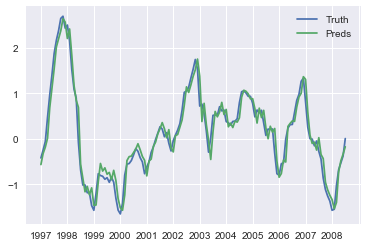

Test MRSE: 0.233081194526208
Test RE: 0.2312928232781944
Test ERROR: 0.2228015412534291


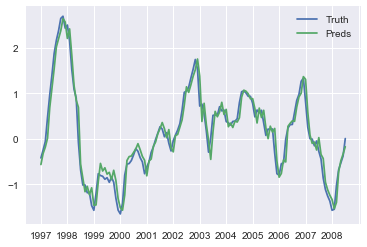

Test MRSE: 0.23306985832597818
Test RE: 0.23128157405767388
Test ERROR: 0.2227907050172055
epoch:   1 loss: 32.39909866


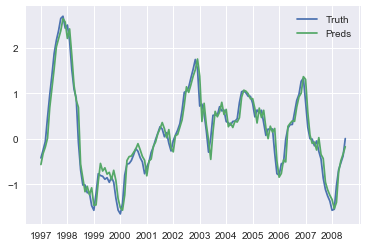

Test MRSE: 0.23296810044640334
Test RE: 0.23118059693978368
Test ERROR: 0.22269343499741676


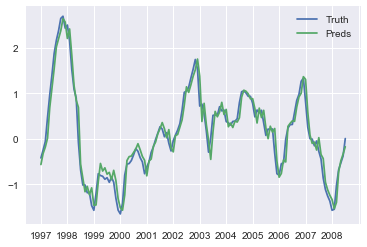

Test MRSE: 0.23285156247678213
Test RE: 0.23106495313562525
Test ERROR: 0.22258203673854418


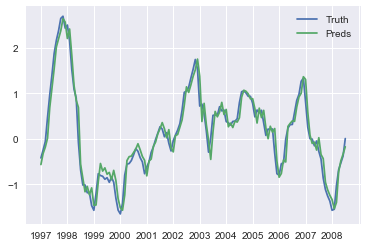

Test MRSE: 0.23273779317566198
Test RE: 0.2309520567566962
Test ERROR: 0.2224732850407145


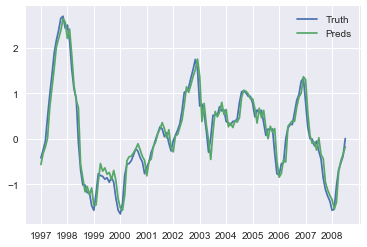

Test MRSE: 0.23263179163996678
Test RE: 0.23084686854315284
Test ERROR: 0.22237195852410674


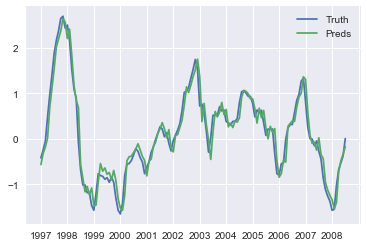

Test MRSE: 0.23253675906360827
Test RE: 0.23075256512698045
Test ERROR: 0.22228111719937008
epoch:   6 loss: 32.14223450


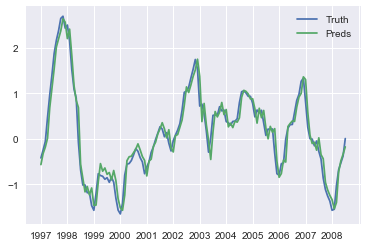

Test MRSE: 0.23245530485105992
Test RE: 0.2306717358913722
Test ERROR: 0.22220325538759136


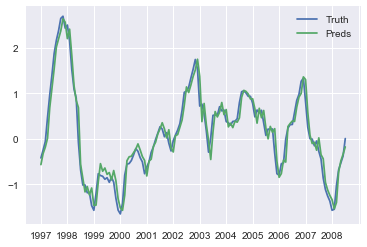

Test MRSE: 0.23238740746970057
Test RE: 0.23060435946892113
Test ERROR: 0.2221383525058094


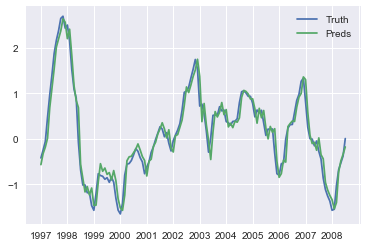

Test MRSE: 0.23233043224065061
Test RE: 0.23054782139595184
Test ERROR: 0.22208389007321633


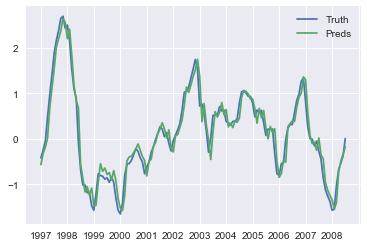

Test MRSE: 0.2322821002138393
Test RE: 0.2304998602081835
Test ERROR: 0.2220376896489936


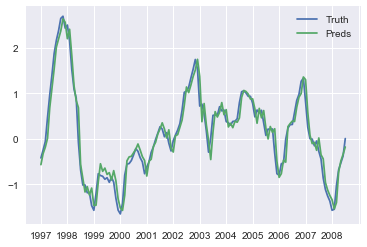

Test MRSE: 0.2322410435574357
Test RE: 0.23045911856880216
Test ERROR: 0.22199844372722782
epoch:  11 loss: 32.07187042


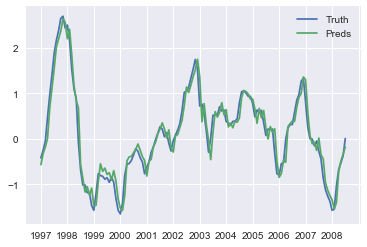

Test MRSE: 0.23220569143320297
Test RE: 0.2304240376922034
Test ERROR: 0.22196465074885544


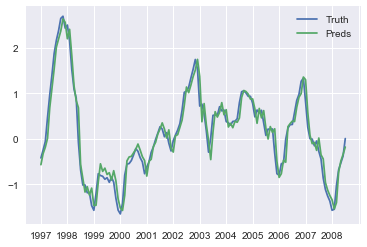

Test MRSE: 0.2321748994232563
Test RE: 0.23039348194132245
Test ERROR: 0.2219352167686137


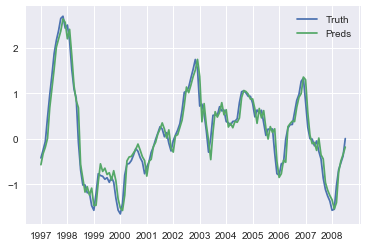

Test MRSE: 0.2321486174191314
Test RE: 0.23036740159216426
Test ERROR: 0.22191009388798766


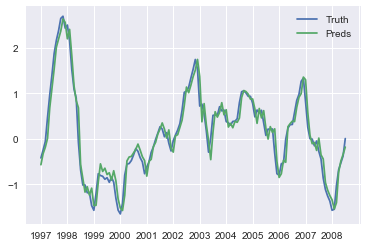

Test MRSE: 0.23212614295928866
Test RE: 0.23034509957299343
Test ERROR: 0.22188861062632004


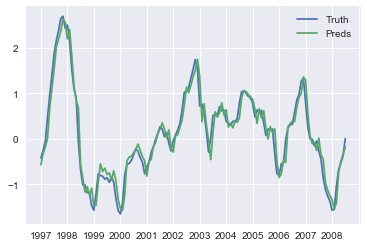

Test MRSE: 0.23210676686305381
Test RE: 0.2303258721444942
Test ERROR: 0.22187008908015513
epoch:  16 loss: 32.02974670


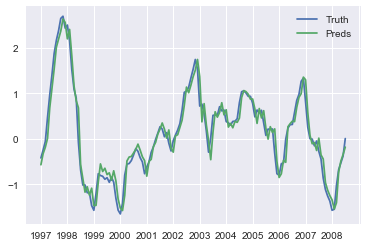

Test MRSE: 0.23209132586379896
Test RE: 0.2303105496200016
Test ERROR: 0.22185532908014968


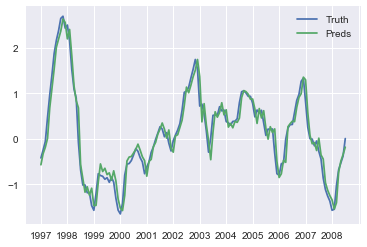

Test MRSE: 0.2320762244929478
Test RE: 0.2302955641180325
Test ERROR: 0.22184089372980956


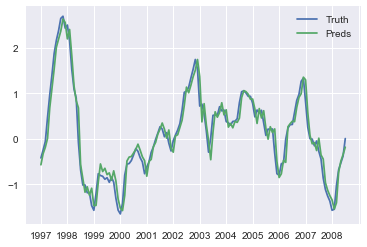

Test MRSE: 0.23206409509927028
Test RE: 0.2302835277900309
Test ERROR: 0.22182929928259854


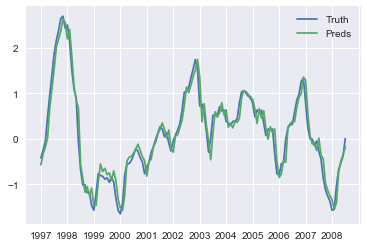

Test MRSE: 0.23205256356813142
Test RE: 0.23027208473732452
Test ERROR: 0.22181827633020648


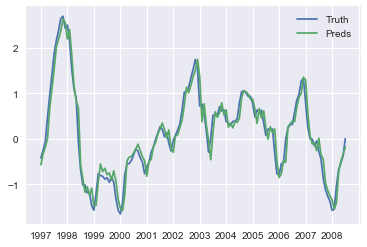

Test MRSE: 0.23204124529361822
Test RE: 0.2302608533049813
Test ERROR: 0.22180745722911593
epoch:  21 loss: 31.99998657


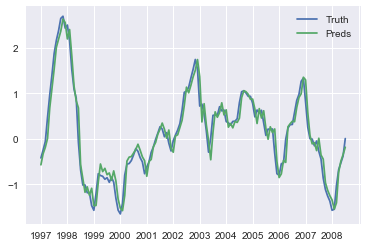

Test MRSE: 0.23203093318151347
Test RE: 0.23025062031502466
Test ERROR: 0.22179759991533657


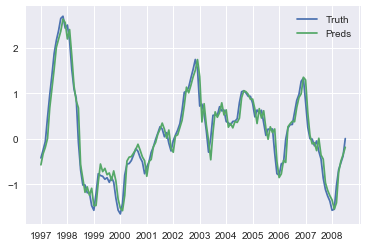

Test MRSE: 0.232019908524982
Test RE: 0.23023968024780894
Test ERROR: 0.22178706148270158


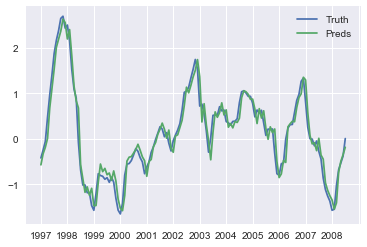

Test MRSE: 0.2320077503044791
Test RE: 0.23022761531416266
Test ERROR: 0.22177543948002373


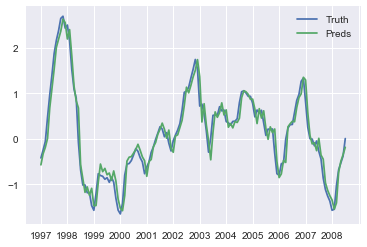

Test MRSE: 0.2319958796380405
Test RE: 0.2302158357282533
Test ERROR: 0.22176409234932273


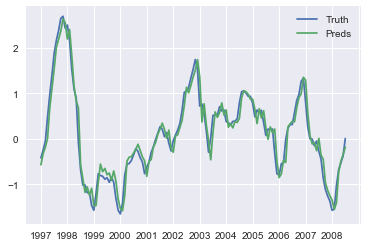

Test MRSE: 0.23198304598983588
Test RE: 0.230203100549286
Test ERROR: 0.22175182470754365
epoch:  26 loss: 31.97859900


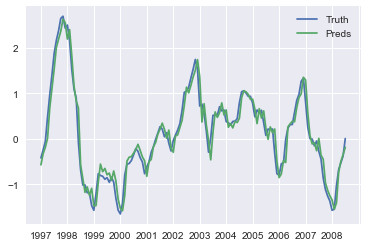

Test MRSE: 0.23197140433159366
Test RE: 0.23019154821445284
Test ERROR: 0.22174069648501854


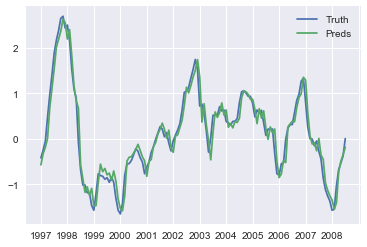

Test MRSE: 0.23196101926675877
Test RE: 0.2301812428315133
Test ERROR: 0.2217307694359662


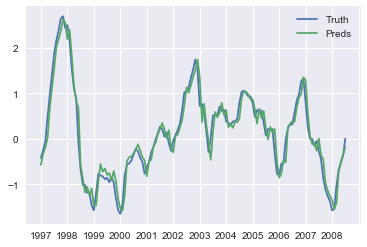

Test MRSE: 0.2319526344476185
Test RE: 0.23017292234690462
Test ERROR: 0.22172275441514316


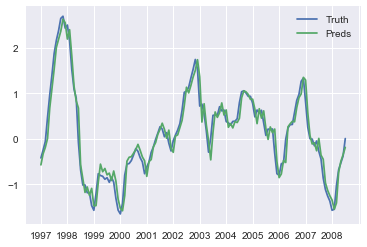

Test MRSE: 0.23194413175755482
Test RE: 0.2301644848957654
Test ERROR: 0.2217146267218952


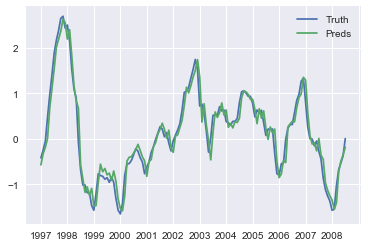

Test MRSE: 0.2319367987694547
Test RE: 0.2301572081717715
Test ERROR: 0.22170761714287693
epoch:  31 loss: 31.96434638


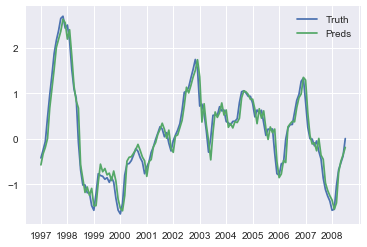

Test MRSE: 0.23192943864783935
Test RE: 0.2301499045224507
Test ERROR: 0.22170058162702141


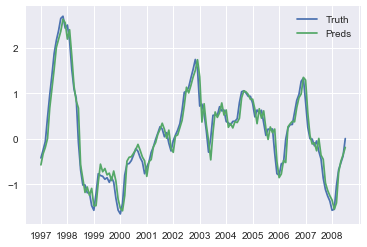

Test MRSE: 0.2319281250387491
Test RE: 0.23014860099234058
Test ERROR: 0.22169932595244624


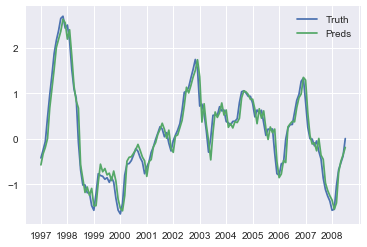

Test MRSE: 0.2319252747445967
Test RE: 0.23014577256775223
Test ERROR: 0.22169660136571384


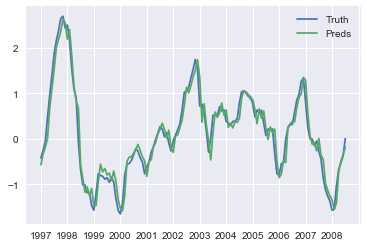

Test MRSE: 0.231923158988939
Test RE: 0.23014367304573619
Test ERROR: 0.22169457892189373
Epoch    35: reducing learning rate of group 0 to 1.0000e-04.


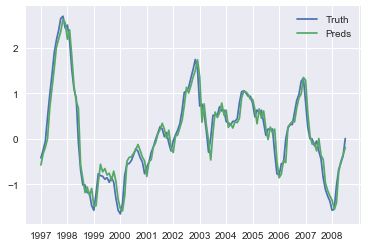

Test MRSE: 0.23194991027394676
Test RE: 0.23017021907510737
Test ERROR: 0.22172015038656018
epoch:  36 loss: 31.88633293


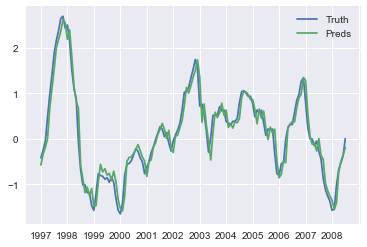

Test MRSE: 0.23198626187897264
Test RE: 0.23020629176374371
Test ERROR: 0.22175489876530977


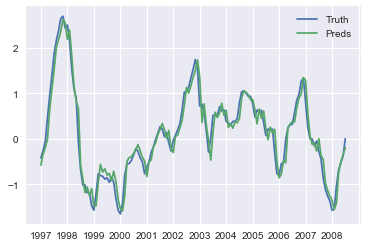

Test MRSE: 0.23202491276379522
Test RE: 0.2302446460904022
Test ERROR: 0.22179184501799562


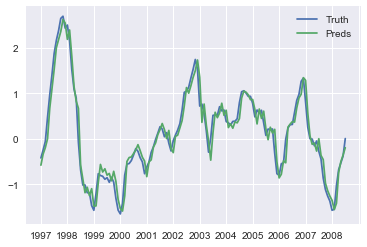

Test MRSE: 0.2320619899087456
Test RE: 0.23028143875208434
Test ERROR: 0.22182728693795406


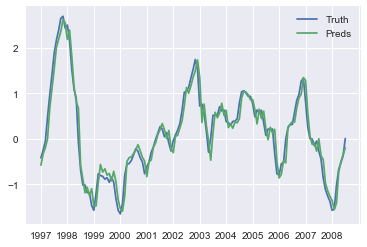

Test MRSE: 0.23209571628748402
Test RE: 0.2303149063571102
Test ERROR: 0.22185952587159732
Epoch    40: reducing learning rate of group 0 to 1.0000e-05.


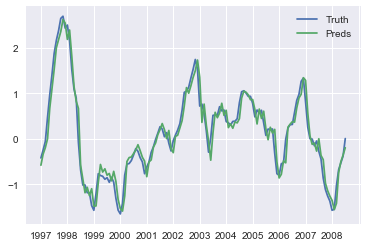

Test MRSE: 0.23209987740995122
Test RE: 0.23031903555236938
Test ERROR: 0.22186350347477082
epoch:  41 loss: 31.83797315


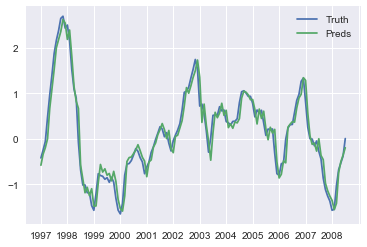

Test MRSE: 0.23210400777320586
Test RE: 0.23032313422442344
Test ERROR: 0.22186745167531505


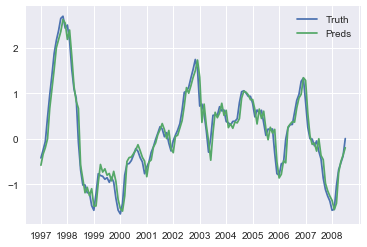

Test MRSE: 0.2321081023398041
Test RE: 0.23032719737447951
Test ERROR: 0.22187136565795404


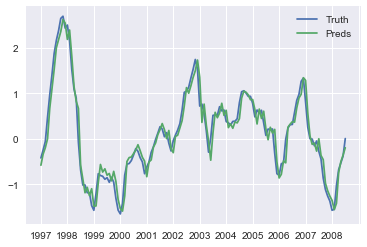

Test MRSE: 0.2321121578699951
Test RE: 0.2303312217876445
Test ERROR: 0.2218752423258207


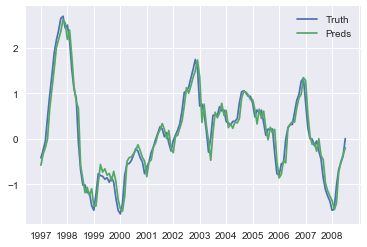

Test MRSE: 0.2321161713764299
Test RE: 0.23033520449949066
Test ERROR: 0.22187907882331817
Epoch    45: reducing learning rate of group 0 to 1.0000e-06.
LR lower than threshold {lr_threshold}. stopping training
epoch:  46 loss: 0.1143083945


In [67]:
layers = [1]
sizes = [32]
epochs = 50
loss_function = nn.MSELoss()
input_size=1
output_size=1
skip_cnt = 0
lr_threshold = 1e-5
best_test_metric = np.inf
best_path = None
for a,l in enumerate(layers):
    for b,s in enumerate(sizes):
        if (a*len(sizes))+(b)<skip_cnt:
            print(f'Skipping num_hidden_layers: {l} hidden_layer_size: {s}')
        else:
            num_hidden_layers=l
            hidden_layer_size=s
            
            prev_running_loss = np.inf
            model = LSTM(input_size,hidden_layer_size,num_hidden_layers,output_size)
            print(model)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=4)
            #best_model_params = model.state_dict()
            #PATH = f'models/best_r2n2_model_{p}_{l}_{s}.pth'

            for i in range(epochs):
                running_loss = 0.0
                cnt=0
                for seq, labels in train_inout_seq:
                    optimizer.zero_grad()
            #         model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
            #                         torch.zeros(1, 1, model.hidden_layer_size))

                    y_pred = model(seq)
                    single_loss = loss_function(y_pred, labels)
                    single_loss.backward()
                    optimizer.step()
                    current_loss = single_loss.item()
                    running_loss += current_loss
                current_lr = get_lr(optimizer)
                if current_lr < lr_threshold:
                    print('LR lower than threshold {lr_threshold}. stopping training')
                    break
                    
#                 if running_loss > prev_running_loss:
#                     print('Training loss started to increase. stopping training...')
#                     prev_running_loss = running_loss
#                     cnt += 1
#                     if cnt > 4:   
#                         break
#                 else:
#                     cnt=0
                prev_running_loss = running_loss
                test_mrse,test_re,test_error,a1,p1 = evaluate_r2n2(rescale=False,display_plots=True)
                if i%5 == 1:
                    print(f'epoch: {i:3} loss: {running_loss:10.8f}')
                test_metric = test_error
                scheduler.step(test_error)
                if(test_metric < best_test_metric):
                    count = 0
                    best_test_metric = test_metric
                    best_path = PATH
                    #torch.save({
                    #    'state_dict': model.state_dict(),
                    #    }, PATH)
                    #print(f"Best Model saved at epoch: {i} with metric: {best_test_metric} num_hidden_layers: {l} hidden_layer_size: {s}")
                else:
                    count+=1
            #     if(count >= 5):
            #         print("Validation has not improved since 5 epochs. Early Stopping...")
            #         break
            print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')